# There is no provided Pytorch Code for this Section
This is my (Kaleb's) best attempt at implementing that

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision import models
from torch import nn
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from skimage.io import imread
from skimage.transform import resize
import os
import cv2
from PIL import Image
torch.manual_seed(42)
np.random.seed(42)

![Image Algorithms](https://cdn-images-1.medium.com/max/840/1*Hz6t-tokG1niaUfmcysusw.jpeg)

## Naive Approach to Object Detection

* Break image into tiles
* Run CNN image classified through each time
* Select tiles with activation above the threshold

Let's read sample image to play with and pad it to square dimension:

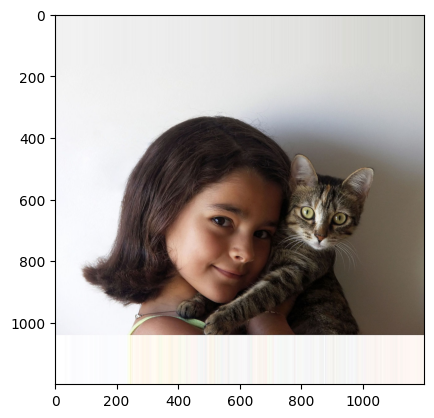

In [2]:
img = cv2.imread('images/1200px-Girl_and_cat.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = np.pad(img,((158,158),(0,0),(0,0)),mode='edge')
plt.imshow(img)

In [3]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1) # vgg = keras.applications.vgg16.VGG16(weights='imagenet')
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Let's define a function that will predict the probability of a cat on the image. Since ImageNet contains a number of classes for cats, indexed from 281 to 294, we will just add probabilities for those classes to get overall 'cat' probability:

In [4]:
def predict(img):
    # Resize the image to 224x224 using OpenCV
    im = cv2.resize(img, (224, 224))
    
    # Convert BGR (OpenCV format) to RGB (PIL format)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Convert the image to a PIL image
    im_pil = Image.fromarray(im)
    
    # Define the standard transformations
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Apply the transformations
    im_tensor = preprocess(im_pil)
    
    # Add a batch dimension
    im_tensor = im_tensor.unsqueeze(0)
    
    # Perform inference
    with torch.no_grad():
        output = vgg16(im_tensor)
    
    # Convert the output to a numpy array
    output_np = output.numpy()[0]
    
    # Sum the predictions for the cat classes (281 to 294)
    cat_class_sum = np.sum(output_np[281:295])  # 294 is inclusive
    
    return cat_class_sum
predict(img)

41.782906

Next function will build a heatmap of probabilities, dividing the image into $n\times n$ squares:

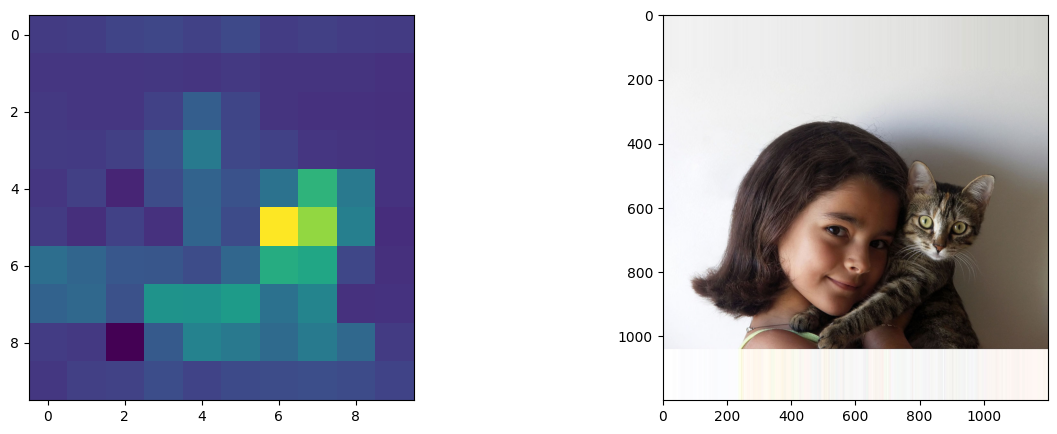

In [5]:
def predict_map(img,n):
  dx = img.shape[0] // n
  res = np.zeros((n,n),dtype=np.float32)
  for i in range(n):
    for j in range(n):
      im = img[dx*i:dx*(i+1),dx*j:dx*(j+1)]
      r = predict(im)
      res[i,j] = r
  return res

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[1].imshow(img)
ax[0].imshow(predict_map(img,10))

## Detecting Simple Objects

To give more precise location of a bounding box, we need to run **regression model** to predict bounding box coordinates. Let's start with simple example of having black rectangles in 32x32 images, which we want to detect. The idea and some code are borrowed from [this blog post](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491).

The following function will generate a bunch of sample images:

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.8
lr = 1e-3
weight_decay = 1e-6
batch_size = 64
epochs = 30

In [7]:
def generate_images(num_imgs, img_size=8, min_object_size = 1, max_object_size = 4):
    bboxes = np.zeros((num_imgs, 4))
    imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

    for i_img in range(num_imgs):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img] = [x, y, w, h]
    return imgs, bboxes

imgs, bboxes = generate_images(100000)
print(f"Images shape = {imgs.shape}")
print(f"BBoxes shape = {bboxes.shape}")

Images shape = (100000, 8, 8)
BBoxes shape = (100000, 4)


To make outputs of the network in the range [0;1], we will divide `bboxes` by the image size:

In [8]:
bb = bboxes/8.0
bb[0]

array([0.25 , 0.5  , 0.375, 0.125])

In [9]:
# def load_dataset(train_part, images, bboxes):
#     indices = np.random.permutation(range(len(images)))
#     train_part = int(train_part * len(images))
#     train_ind = indices[:train_part]
#     test_ind = indices[train_part:]

#     train_dataset = (images[train_ind, :, :], bboxes[train_ind, :])
#     test_dataset = (images[test_ind, :, :], bboxes[test_ind, :])

#     return train_dataset, test_dataset


# train_dataset, test_dataset = load_dataset(0.8, imgs, bboxes)
def load_dataset(train_part, images, bboxes):
    # Shuffle the indices
    indices = np.random.permutation(range(len(images)))
    train_part = int(train_part * len(images))
    train_ind = indices[:train_part]
    test_ind = indices[train_part:]

    # Create training and testing datasets
    train_images, train_bboxes = images[train_ind, :, :], bboxes[train_ind, :]
    test_images, test_bboxes = images[test_ind, :, :], bboxes[test_ind, :]

    # Convert to torch tensors and ensure they are of type float
    train_images = torch.tensor(train_images, dtype=torch.float32)
    train_bboxes = torch.tensor(train_bboxes, dtype=torch.float32)
    test_images = torch.tensor(test_images, dtype=torch.float32)
    test_bboxes = torch.tensor(test_bboxes, dtype=torch.float32)

    train_dataset = (train_images, train_bboxes)
    test_dataset = (test_images, test_bboxes)

    return train_dataset, test_dataset
train_dataset, test_dataset = load_dataset(train_size, imgs, bboxes)

In [10]:
train_dataloader = torch.utils.data.DataLoader(list(zip(train_dataset[0], train_dataset[1])), batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(list(zip(test_dataset[0], test_dataset[1])), batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

In our simple example, we will use dense neural network. In real life, when objects have more complex shape, it definitely makes sense to use CNNs for the task like this. We will use stochastic gradient descent optimizer and mean squared error (MSE) as the metrics, because our task is **regression**.

In [11]:
# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(8,8)),
#     keras.layers.Dense(200, activation='relu'),
#     keras.layers.Dropout(0.2),
#     keras.layers.Dense(4)
# ])
# model.compile('sgd','mse')
# model.summary()

class KeiModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Define layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8*8, 200)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(200, 4)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Let's train our network. We will also normalize the input data (by subtracting mean and dividing by standard deviation) for slightly better performance.

In [12]:
imgs_norm = (imgs-np.mean(imgs))/np.std(imgs)

Going off script now for a bit as Keras has very easy implementation of training while PyTorch does not

In [13]:
def train(dataloaders, model, loss_fn, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)
            loss = loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds = model(imgs)
                loss = loss_fn(preds, labels)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [14]:
model = KeiModel()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()

train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|█████████████████████████████████████████| 30/30 [10:03<00:00, 20.12s/it, train loss:=-6.67e+6, test loss:=-6.9e+6]


We seem to have relatively good loss, let's see how it translates into more tangible metrics, such as mAP. First, let's define IOU metric between two bounding boxes:

In [16]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]
    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

We will now generate 500 test images, and plot first 5 of them to visualize how accurate we are. We will print out IOU metric as well.

In [24]:
def plotn(n, data, only_mask=False):
    images, masks = data[0], data[1]
    fig, ax = plt.subplots(1, n)
    fig1, ax1 = plt.subplots(1, n)
    for i, (img, mask) in enumerate(zip(images, masks)):
        if i == n:
            break
        if not only_mask:
            ax[i].imshow(torch.permute(img, (1, 2, 0)))
        else:
            ax[i].imshow(img[0])
        ax1[i].imshow(mask[0])
        ax[i].axis('off')
        ax1[i].axis('off')
    plt.show()

TypeError: Invalid shape () for image data

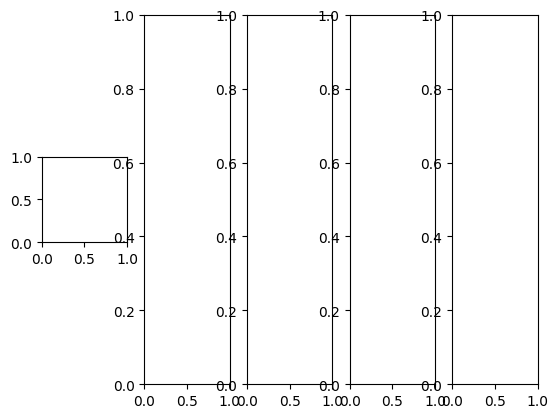

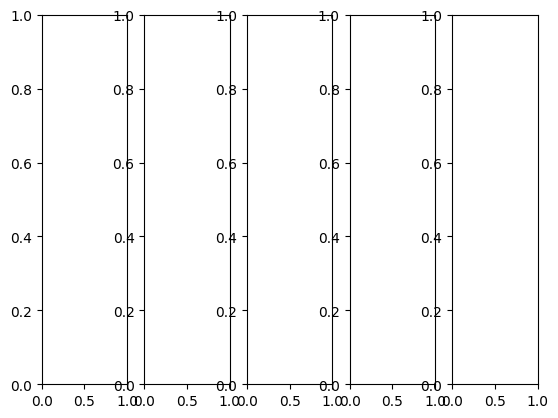

In [34]:
model.eval()
plots = 5

predictions = []
actual = []
images, bboxes = test_dataset[0], test_dataset[1]
for i, (img, bbox) in enumerate(zip(images, bboxes)):
    if i == plots:
        break
    img = img.to(device).unsqueeze(0)
    predictions.append((model(img).detach().cpu()[0] > 0.5).float())
    actual.append(mask)

# Plot the results
plotn(plots, (predictions, actual), only_mask=True)

Now to calculate mean precision over all cases, we just need to go over all our test samples, compute IoU, and calculate mean:

In [ ]:
np.array([IOU(a,b) for a,b in zip(test_bboxes,bb_res)]).mean()